## Goal
Find the topics in the given document where each row belongs to one of various topics.

## My Approach
I'll start by exploring the data, then use Spacy for text preprocessing, and finally apply topic modeling techniques to discover the underlying topics.

In [ ]:
import pandas as pd
import numpy as np
import spacy
from collections import Counter
import re

# For topic modeling - I'll try a few approaches
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import warnings
warnings.filterwarnings('ignore')


Libraries loaded!


In [ ]:
## Step 1: Loading the Data
#Sir, you said to use small DataFrames for debugging, so I'll start by loading just a few rows first to see what we're working with.

# Let me read the file first with just a few lines to see the structure. You said don't wait for errors, debug early!

with open('TopicModellingAssignment.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

print(f"Total lines: {len(lines)}")
print("\nFirst 5 lines:")
for i, line in enumerate(lines[:5], 1):
    print(f"{i}: {line.strip()[:100]}...")  # Show first 100 chars


Total lines: 337

First 5 lines:
1: Ottomans was good at making map....
2: Romans are used to theater for cricitising their government.Sometimes they used to theater for wrong...
3: the calender...
4: "1-Consunls 2-assemblie...
5: 12 law of something...


In [ ]:
# Now let me create a small DataFrame first
# I'll start with just 20 rows to understand the data better

small_df = pd.DataFrame({
    'text': lines[:20]
})

print("Small DataFrame shape:", small_df.shape)
print("\nSample rows:")
small_df.head(10)


Small DataFrame shape: (20, 1)

Sample rows:


,text
0,Ottomans was good at making map.\n
1,Romans are used to theater for cricitising t...
2,the calender \n
3,"""1-Consunls 2-assemblie\n"
4,12 law of something\n
5,According to laws the man is not guilty until...
6,"If someone were to commit a crime, he would b..."
7,"In Roma, Senators prohibited to involve in tr..."
8,The Conflict political struggle between the c...
9,what is conflict of Interest. How did Romans ...


## Observations So Far

Looking at the data, I notice:
- Some rows are very short (like "the calender")
- Some are longer explanations
- There are typos and informal language
- Some rows seem to be about Romans, Greeks, Kepler, Conflict of Interest, etc.

This is good. I can already see potential topics emerging But I need to process this properly.


In [ ]:
# Now load the full dataset
# But I'll keep checking with small samples as I go

df = pd.DataFrame({
    'text': [line.strip() for line in lines]
})

print(f"Full dataset: {len(df)} rows")
print(f"Average text length: {df['text'].str.len().mean():.1f} characters")
print(f"Shortest: {df['text'].str.len().min()} chars")
print(f"Longest: {df['text'].str.len().max()} chars")

# Lets see some statistics
df['word_count'] = df['text'].str.split().str.len()
print(f"\nAverage words per row: {df['word_count'].mean():.1f}")
print(f"Rows with less than 5 words: {(df['word_count'] < 5).sum()}")


Full dataset: 337 rows
Average text length: 152.4 characters
Shortest: 8 chars
Longest: 539 chars

Average words per row: 24.5
Rows with less than 5 words: 31


## Step 2: Loading Spacy Model

I'll use Spacy for preprocessing. This will help with:
- Tokenization, Lemmatization, Removing stopwords, POS tagging if needed

In [ ]:
# Load Spacy model - I'll use the English model
try:
    nlp = spacy.load("en_core_web_sm")
    print("Spacy model loaded successfully!")
except OSError:
    print("Model not found.")
    raise


Spacy model loaded successfully!


## Step 3: Text Preprocessing Function

I'll create a function to clean the text. This is important because:
- The data has typos and informal language
- I noticed that some rows are very short
- I need to remove noise but keep meaningful content

Let me test it on a small sample first (debugging).


In [ ]:
def preprocess_text(text, nlp_model, min_length=2):
    """
    Clean and preprocess text using Spacy
    - Convert to lowercase
    - Remove extra whitespace
    - Use Spacy for tokenization and lemmatization
    - Filter out stopwords, punctuation and very short tokens
    """
    if pd.isna(text) or text == "":
        return ""
    
    # Basic cleaning
    text = str(text).lower().strip()
    text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single
    
    # Process with Spacy
    doc = nlp_model(text)
    
    # Extract lemmatized tokens
    tokens = []
    for token in doc:
        # Keep only alphabetic tokens that are not stopwords and have minimum length
        if (token.is_alpha and 
            not token.is_stop and 
            len(token.lemma_) >= min_length):
            tokens.append(token.lemma_)
    
    return ' '.join(tokens)

# Test on small sample first
test_texts = small_df['text'].head(5)
print("Testing preprocessing on first 5 rows:\n")
for i, original in enumerate(test_texts, 1):
    processed = preprocess_text(original, nlp)
    print(f"Row {i}:")
    print(f"  Original: {original[:80]}...")
    print(f"  Processed: {processed[:80]}...")
    print()

Testing preprocessing on first 5 rows:

Row 1:
  Original:   Ottomans was good at making map.
...
  Processed: othman good make map...

Row 2:
  Original:   Romans are used to theater for cricitising their government.Sometimes they use...
  Processed: romans theater cricitise theater wrong politic decision cricitise bad politician...

Row 3:
  Original:   the calender 
...
  Processed: calender...

Row 4:
  Original:  "1-Consunls 2-assemblie
...
  Processed: consunls assemblie...

Row 5:
  Original:  12 law of something
...
  Processed: law...



## Apply preprocessing to small sample first
#I Noticed some rows become very short after preprocessing (like "calender" becomes just "calender").
#This might be a problem for topic modeling. Lets check how many rows become too short.

In [ ]:
small_df['processed'] = small_df['text'].apply(lambda x: preprocess_text(x, nlp))
small_df['processed_length'] = small_df['processed'].str.split().str.len()

print("After preprocessing (small sample):")
print(small_df[['text', 'processed', 'processed_length']].head(10))
print(f"\nRows with less than 3 words after processing: {(small_df['processed_length'] < 3).sum()}")

After preprocessing (small sample):
                                                text  \
0                 Ottomans was good at making map.\n   
1    Romans are used to theater for cricitising t...   
2                                    the calender \n   
3                          "1-Consunls 2-assemblie\n   
4                              12 law of something\n   
5   According to laws the man is not guilty until...   
6   If someone were to commit a crime, he would b...   
7   In Roma, Senators prohibited to involve in tr...   
8   The Conflict political struggle between the c...   
9   what is conflict of Interest. How did Romans ...   

                                           processed  processed_length  
0                               othman good make map                 4  
1  romans theater cricitise theater wrong politic...                10  
2                                           calender                 1  
3                                 consunls assemblie   

## Issue I Found

Some rows become very short after preprocessing. This is a problem because:
- Topic modeling needs enough words to work
- Very short texts might not be useful

I have two options:
1. Filter out very short texts
2. Keep them and see what happens

Let me process the full dataset but keep track of what gets filtered.


In [ ]:
# Process full dataset
df['processed'] = df['text'].apply(lambda x: preprocess_text(x, nlp))
df['processed_length'] = df['processed'].str.split().str.len()

print(f"\nProcessing complete!")
print(f"Rows with 0 words after processing: {(df['processed_length'] == 0).sum()}")
print(f"Rows with 1-2 words: {((df['processed_length'] >= 1) & (df['processed_length'] <= 2)).sum()}")
print(f"Rows with 3+ words: {(df['processed_length'] >= 3).sum()}")

# Show some examples of very short ones
print("\nExamples of very short processed texts:")
short_examples = df[df['processed_length'] <= 2][['text', 'processed']].head(5)
print(short_examples)


Processing full dataset... This might take a moment...

Processing complete!
Rows with 0 words after processing: 0
Rows with 1-2 words: 21
Rows with 3+ words: 316

Examples of very short processed texts:
                       text           processed
2              the calender            calender
3   "1-Consunls 2-assemblie  consunls assemblie
4       12 law of something                 law
10                12 tablet              tablet
13                 monarchy            monarchy


In [ ]:
## Decision time:I think I should filter out rows with less than 3 words after preprocessing.
# These are probably not useful for topic modeling. But Im gonna keep the original data too, just in case I need to look back.
# Filter to keep only rows with meaningful content
df_filtered = df[df['processed_length'] >= 3].copy()

print(f"Original rows: {len(df)}")
print(f"After filtering (3+ words): {len(df_filtered)}")
print(f"Removed: {len(df) - len(df_filtered)} rows")

# Lets see what we're working with now
print(f"\nFiltered dataset stats:")
print(f"Average words: {df_filtered['processed_length'].mean():.1f}")
print(f"Min words: {df_filtered['processed_length'].min()}")
print(f"Max words: {df_filtered['processed_length'].max()}")


Original rows: 337
After filtering (3+ words): 316
Removed: 21 rows

Filtered dataset stats:
Average words: 13.4
Min words: 3
Max words: 53


In [ ]:
# Step 4: Exploring What Topics Might Exist
#Before doing topic modeling, let me manually look at some examples to see if I can spot patterns. 
# This will help me understand what to expect.
# Let me look for keywords that might indicate topics
keywords_to_check = ['roman', 'greek', 'kepler', 'conflict', 'interest', 'planet', 
                     'democracy', 'theater', 'senate', 'law', 'information', 'dissemination']

print("Looking for potential topic indicators:\n")
for keyword in keywords_to_check:
    count = df_filtered['processed'].str.contains(keyword, case=False, na=False).sum()
    print(f"{keyword}: appears in {count} rows")


Looking for potential topic indicators:

roman: appears in 121 rows
greek: appears in 120 rows
kepler: appears in 51 rows
conflict: appears in 37 rows
interest: appears in 38 rows
planet: appears in 55 rows
democracy: appears in 25 rows
theater: appears in 21 rows
senate: appears in 19 rows
law: appears in 41 rows
information: appears in 26 rows
dissemination: appears in 14 rows


## My Observations

From the keyword search, I can see:
- "roman" and "greek" appear a lot -> probably topics about ancient civilizations
- "kepler" appears -> astronomy topic
- "conflict" and "interest" -> probably about conflict of interest
- "planet" - astronomy
- "law", "senate" - legal/government topics
- "information, "dissemination" - information sharing topic

So I'm expecting maybe 4-6 main topics. Let me try topic modeling now


## Step 5: Preparing for Topic Modeling

I'll use LDA (Latent Dirichlet Allocation) which I learned is a common approach. But first I need to:
1. Create a document-term matrix
2. Decide how many topics to look for

Let me start with a small sample to test

In [15]:
# Test on small sample first
test_sample = df_filtered.head(50)  # Just 50 rows to test

print(f"Testing on {len(test_sample)} rows first...")

# Create vectorizer - I'll limit features to see what happens
vectorizer = CountVectorizer(
    max_features=100,  # Limit to 100 most common words for testing
    min_df=2,  # Word must appear in at least 2 documents
    max_df=0.95  # Word can't appear in more than 95% of documents
)

# Create document-term matrix
dtm = vectorizer.fit_transform(test_sample['processed'])

print(f"Document-term matrix shape: {dtm.shape}")
print(f"Number of features (words): {len(vectorizer.get_feature_names_out())}")

# Show some feature names
print(f"\nSample features: {list(vectorizer.get_feature_names_out()[:20])}")


Testing on 50 rows first...
Document-term matrix shape: (50, 89)
Number of features (words): 89

Sample features: ['accord', 'action', 'agriculture', 'algebra', 'ancient', 'apply', 'area', 'aristocrat', 'assembilie', 'assembly', 'avoid', 'bad', 'book', 'build', 'calculus', 'center', 'choose', 'conflict', 'consul', 'create']


In [ ]:
# Testing LDA on Small Sample:
#Now let me try LDA with different numbers of topics to see what works best.
#  I'll start with 5 topics since I saw about that many themes

# Try LDA with 5 topics on small sample
n_topics = 5
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=10,  # Keep it small for testing
    learning_method='online'
)

print(f"Fitting LDA with {n_topics} topics on test sample...")
lda.fit(dtm)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Display topics
print("\nTopics found (top 10 words per topic):\n")
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


Fitting LDA with 5 topics on test sample...

Topics found (top 10 words per topic):

Topic 1: rule, good, person, conflict, think, science, man, mean, idea, people
Topic 2: interest, conflict, roman, romans, senate, law, decision, apply, power, thing
Topic 3: government, people, assembly, consul, senate, political, say, like, senato, crime
Topic 4: planet, sun, kepler, think, center, earth, law, universe, slow, get
Topic 5: people, greek, find, happen, table, lose, thing, theater, decision, bad


## What I Notice

The topics look reasonable I can see words related to:
- Romans, Greeks, government
- Planets, Kepler, astronomy
- Conflict, interest
- etc.

But this is just 50 rows as we tested on a small dataset. Let me try with the full dataset now, but I'll experiment with different numbers of topics.

In [ ]:
# Now process full dataset
print("Processing full dataset for topic modeling...")

# Use more features for full dataset
vectorizer_full = CountVectorizer(
    max_features=500,  # More words for full dataset
    min_df=3,  # Word must appear in at least 3 documents
    max_df=0.9  # Word can't appear in more than %90 of documents
)

dtm_full = vectorizer_full.fit_transform(df_filtered['processed'])

print(f"Full document-term matrix shape: {dtm_full.shape}")
print(f"Number of unique words: {len(vectorizer_full.get_feature_names_out())}")


Processing full dataset for topic modeling...
Full document-term matrix shape: (316, 291)
Number of unique words: 291


## Step 6: Finding the Right Number of Topics

This is tricky bcs I don't know how many topics there are. Let me try different numbers and see which makes sense. I'll try 4, 5, 6, and 7 topics.

In [18]:
# Try different numbers of topics
feature_names_full = vectorizer_full.get_feature_names_out()

for n_topics in [4, 5, 6, 7]:
    print(f"\n{'='*60}")
    print(f"Testing with {n_topics} topics:")
    print('='*60)
    
    lda_test = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=20,
        learning_method='online'
    )
    
    lda_test.fit(dtm_full)
    
    # Show top words for each topic
    for topic_idx, topic in enumerate(lda_test.components_):
        top_words_idx = topic.argsort()[-10:][::-1]
        top_words = [feature_names_full[i] for i in top_words_idx]
        print(f"\nTopic {topic_idx + 1}:")
        print(f"  {', '.join(top_words)}")



Testing with 4 topics:

Topic 1:
  interest, conflict, government, romans, people, roman, power, senate, person, different

Topic 2:
  greek, romans, science, humanity, democracy, law, theatre, use, like, thing

Topic 3:
  theater, greek, book, drama, romans, improve, calendar, academy, internet, invent

Topic 4:
  planet, kepler, greek, earth, sun, information, orbit, universe, think, center

Testing with 5 topics:

Topic 1:
  interest, conflict, government, romans, roman, people, senate, power, person, consul

Topic 2:
  greek, romans, science, humanity, use, lot, today, theory, like, contribution

Topic 3:
  theatre, democracy, theater, greek, invent, book, romans, newspaper, printing, found

Topic 4:
  planet, kepler, earth, sun, greek, universe, orbit, center, think, information

Topic 5:
  law, table, find, area, world, use, path, opinion, day, twelwe

Testing with 6 topics:

Topic 1:
  interest, conflict, romans, government, roman, senate, power, people, person, consul

Topic 2

## My Analysis

Looking at the results:
- 4 topics : Might be too few - some topics seem mixed
- 5 topics: Looks good! Topics seem distinct
- 6 topics: Also good, but one topic might be splitting something
- 7 topics: Some topics might be too similar

I think 5 or 6 topics works best. Let me go with 5 topics for now and see what documents belong to which topic.


In [19]:
# Final model with 5 topics
n_topics_final = 5

lda_final = LatentDirichletAllocation(
    n_components=n_topics_final,
    random_state=42,
    max_iter=30,  # More iterations for better results
    learning_method='online'
)

print(f"Fitting final LDA model with {n_topics_final} topics...")
lda_final.fit(dtm_full)

# Get topic distributions for each document
doc_topic_dist = lda_final.transform(dtm_full)

# Assign each document to its most likely topic
df_filtered['topic'] = doc_topic_dist.argmax(axis=1)

print("\nTopic distribution:")
print(df_filtered['topic'].value_counts().sort_index())


Fitting final LDA model with 5 topics...

Topic distribution:
topic
0    77
1    73
2    62
3    91
4    13
Name: count, dtype: int64


## Step 7: Interpreting the Topics

Now let me look at the actual topics and see what they represent. I'll show:
1. Top words for each topic
2. Sample documents from each topic
3. My interpretation of what each topic is about


In [20]:
# Display final topics with top words
print("="*70)
print("FINAL TOPICS IDENTIFIED")
print("="*70)

for topic_idx, topic in enumerate(lda_final.components_):
    top_words_idx = topic.argsort()[-15:][::-1]  # Top 15 words
    top_words = [feature_names_full[i] for i in top_words_idx]
    top_weights = [topic[i] for i in top_words_idx]
    
    print(f"\n{'='*70}")
    print(f"TOPIC {topic_idx + 1} (appears in {sum(df_filtered['topic'] == topic_idx)} documents)")
    print(f"{'='*70}")
    print(f"Top words: {', '.join(top_words[:10])}")
    print(f"\nTop 15 words with weights:")
    for word, weight in zip(top_words, top_weights):
        print(f"  {word:15s} : {weight:.4f}")


FINAL TOPICS IDENTIFIED

TOPIC 1 (appears in 77 documents)
Top words: interest, conflict, government, romans, roman, people, senate, power, person, consul

Top 15 words with weights:
  interest        : 49.0912
  conflict        : 44.3050
  government      : 39.4989
  romans          : 35.6786
  roman           : 31.1347
  people          : 25.5611
  senate          : 25.3685
  power           : 24.8182
  person          : 21.2314
  consul          : 18.3461
  system          : 15.5818
  rule            : 15.3928
  want            : 15.0756
  thing           : 13.9851
  apply           : 13.8632

TOPIC 2 (appears in 73 documents)
Top words: greek, romans, science, humanity, lot, use, today, theory, contribution, contribute

Top 15 words with weights:
  greek           : 58.4902
  romans          : 53.7060
  science         : 35.3451
  humanity        : 25.7959
  lot             : 15.2685
  use             : 15.2097
  today           : 13.8797
  theory          : 12.3796
  contribution 

## Step 8: Looking at Sample Documents for Each Topic

Let me see actual examples from each topic to understand what they're really about. This will help me name them properly.

In [21]:
# Show sample documents for each topic
print("="*70)
print("SAMPLE DOCUMENTS FOR EACH TOPIC")
print("="*70)

for topic_num in range(n_topics_final):
    topic_docs = df_filtered[df_filtered['topic'] == topic_num]
    
    print(f"\n{'='*70}")
    print(f"TOPIC {topic_num + 1} - {len(topic_docs)} documents")
    print(f"{'='*70}")
    
    # Show 5 random examples
    sample_docs = topic_docs.sample(min(5, len(topic_docs)), random_state=42)
    
    for idx, row in sample_docs.iterrows():
        print(f"\nExample {sample_docs.index.get_loc(idx) + 1}:")
        print(f"  Original: {row['text'][:150]}...")
        print(f"  Processed: {row['processed'][:150]}...")
        print(f"  Topic probability: {doc_topic_dist[df_filtered.index.get_loc(idx), topic_num]:.3f}")


SAMPLE DOCUMENTS FOR EACH TOPIC

TOPIC 1 - 77 documents

Example 1:
  Original: They created Assembly, Senate, Consule....
  Processed: create assembly senate consule...
  Topic probability: 0.550

Example 2:
  Original: Consuls , Assembly, Senato Consuls-Government chose two consuls . They are military and govern head of state . Veto others consuls idea Senato - It ha...
  Processed: consul assembly senato consul government choose consul military govern head state veto consul idea senato power legal rule advise consul king assembly...
  Topic probability: 0.856

Example 3:
  Original: A conflict of interest occurs when an individual's personal interests could compromise his or her judgement, decisions, or actions in the workplace. G...
  Processed: conflict interest occur individual personal interest compromise judgement decision action workplace government agency conflict interest seriously regu...
  Topic probability: 0.927

Example 4:
  Original: Ottomans was good at making map....

## Step 9: My Interpretation of the Topics

Based on the top words and sample documents, here's what I think each topic represents:

Let me write down my thoughts with printing to screen


In [22]:
# Let me create a summary of what I think each topic is about
topic_interpretations = {}

for topic_num in range(n_topics_final):
    topic_docs = df_filtered[df_filtered['topic'] == topic_num]
    
    # Get top words
    top_words_idx = lda_final.components_[topic_num].argsort()[-10:][::-1]
    top_words = [feature_names_full[i] for i in top_words_idx]
    
    # Look at a few sample documents to understand the topic
    samples = topic_docs.sample(min(3, len(topic_docs)), random_state=42)['text'].tolist()
    
    topic_interpretations[topic_num] = {
        'top_words': top_words,
        'sample_docs': samples,
        'count': len(topic_docs)
    }

# Display my interpretations
print("="*70)
print("MY INTERPRETATION OF TOPICS")
print("="*70)

for topic_num, info in topic_interpretations.items():
    print(f"\n{'='*70}")
    print(f"TOPIC {topic_num + 1} ({info['count']} documents)")
    print(f"{'='*70}")
    print(f"Key words: {', '.join(info['top_words'][:8])}")
    print(f"\nSample documents:")
    for i, doc in enumerate(info['sample_docs'], 1):
        print(f"  {i}. {doc[:120]}...")


MY INTERPRETATION OF TOPICS

TOPIC 1 (77 documents)
Key words: interest, conflict, government, romans, roman, people, senate, power

Sample documents:
  1. They created Assembly, Senate, Consule....
  2. Consuls , Assembly, Senato Consuls-Government chose two consuls . They are military and govern head of state . Veto othe...
  3. A conflict of interest occurs when an individual's personal interests could compromise his or her judgement, decisions, ...

TOPIC 2 (73 documents)
Key words: greek, romans, science, humanity, lot, use, today, theory

Sample documents:
  1. build , theater , road,olimpics ,...
  2. Romans were more likely to be engineers, because they invented a lot of practical and useful things like cement, highway...
  3. Romans created power of judgement with helped humanity be in a little less risk and avoid crimes....

TOPIC 3 (62 documents)
Key words: theatre, greek, theater, democracy, invent, book, romans, newspaper

Sample documents:
  1. theater,books,newspaper,rad

## Step 10: Trying a Different Approach - Maybe 6 Topics?

Actually, let me also try 6 topics to see if it gives better separation. I searched on google and saw some ppl on the stackoverflow says that sometimes having one more topic can help separate mixed concepts. So lets try.

In [23]:
# Try 6 topics as an alternative
print("Trying 6 topics as an alternative...")

lda_6 = LatentDirichletAllocation(
    n_components=6,
    random_state=42,
    max_iter=30,
    learning_method='online'
)

lda_6.fit(dtm_full)
doc_topic_dist_6 = lda_6.transform(dtm_full)
df_filtered['topic_6'] = doc_topic_dist_6.argmax(axis=1)

print("\nTopic distribution with 6 topics:")
print(df_filtered['topic_6'].value_counts().sort_index())

print("\n" + "="*70)
print("TOPICS WITH 6 COMPONENTS")
print("="*70)

for topic_idx, topic in enumerate(lda_6.components_):
    top_words_idx = topic.argsort()[-12:][::-1]
    top_words = [feature_names_full[i] for i in top_words_idx]
    print(f"\nTopic {topic_idx + 1}: {', '.join(top_words)}")


Trying 6 topics as an alternative...

Topic distribution with 6 topics:
topic_6
0    75
1    64
2    50
3    77
4    42
5     8
Name: count, dtype: int64

TOPICS WITH 6 COMPONENTS

Topic 1: interest, conflict, romans, government, roman, people, senate, power, person, consul, thing, apply

Topic 2: greek, romans, science, humanity, theatre, democracy, theory, contribution, contribute, use, found, observation

Topic 3: theater, greek, drama, democracy, invent, system, romans, different, improve, academy, like, want

Topic 4: planet, kepler, earth, sun, orbit, universe, think, center, movement, greek, move, retrograde

Topic 5: information, law, greek, book, dissemination, find, today, newspaper, table, lot, term, use

Topic 6: rule, printing, war, invention, government, romans, landmark, hard, think, people, way, economy


## Comparison: 5 vs 6 Topics

Looking at both:
- 5 topics: Topics seem more distinct, each has a clear theme
- 6 topics: One topic might be splitting something that should be together

I think 5 topics is better for this dataset. The topics are:
1. Romans and Government/Legal System** - about Roman government, senate, consuls, laws
2. Greeks vs Romans Contributions** - comparing Greek and Roman contributions to humanity
3. Kepler and Astronomy - about planets, orbits, retrograde movement, heliocentric model
4. Conflict of Interest - about conflict of interest in Roman government
5. Information Dissemination - about how information was shared (theater, books, printing, etc.

Let me verify this by looking at more examples.

In [24]:
# Create a clearer summary with topic names
topic_names = {
    0: "Romans and Government/Legal System",
    1: "Greeks vs Romans Contributions", 
    2: "Kepler and Astronomy",
    3: "Conflict of Interest",
    4: "Information Dissemination"
}

print("="*70)
print("FINAL TOPIC ASSIGNMENTS")
print("="*70)

for topic_num in range(n_topics_final):
    topic_docs = df_filtered[df_filtered['topic'] == topic_num]
    print(f"\n{topic_names[topic_num]}")
    print(f"  Number of documents: {len(topic_docs)}")
    print(f"  Percentage: {len(topic_docs)/len(df_filtered)*100:.1f}%")
    
    # Show top words
    top_words_idx = lda_final.components_[topic_num].argsort()[-8:][::-1]
    top_words = [feature_names_full[i] for i in top_words_idx]
    print(f"  Key words: {', '.join(top_words)}")


FINAL TOPIC ASSIGNMENTS

Romans and Government/Legal System
  Number of documents: 77
  Percentage: 24.4%
  Key words: interest, conflict, government, romans, roman, people, senate, power

Greeks vs Romans Contributions
  Number of documents: 73
  Percentage: 23.1%
  Key words: greek, romans, science, humanity, lot, use, today, theory

Kepler and Astronomy
  Number of documents: 62
  Percentage: 19.6%
  Key words: theatre, greek, theater, democracy, invent, book, romans, newspaper

Conflict of Interest
  Number of documents: 91
  Percentage: 28.8%
  Key words: planet, kepler, earth, sun, greek, universe, orbit, center

Information Dissemination
  Number of documents: 13
  Percentage: 4.1%
  Key words: law, table, find, area, world, use, path, opinion


## Step 11: Checking Topic Quality

Let me check if the topics make sense by looking at documents that have high confidence (high probability) for their assigned topic.


In [25]:
# Check topic confidence
df_filtered['topic_confidence'] = [doc_topic_dist[i, topic] 
                                   for i, topic in enumerate(df_filtered['topic'])]

print("Topic confidence statistics:")
print(df_filtered.groupby('topic')['topic_confidence'].describe())

print("\n" + "="*70)
print("HIGH CONFIDENCE EXAMPLES (confidence > 0.7)")
print("="*70)

high_conf = df_filtered[df_filtered['topic_confidence'] > 0.7]

for topic_num in range(n_topics_final):
    topic_high_conf = high_conf[high_conf['topic'] == topic_num]
    if len(topic_high_conf) > 0:
        print(f"\n{topic_names[topic_num]} - {len(topic_high_conf)} high confidence examples:")
        samples = topic_high_conf.nlargest(3, 'topic_confidence')
        for idx, row in samples.iterrows():
            print(f"  [{row['topic_confidence']:.3f}] {row['text'][:100]}...")


Topic confidence statistics:
       count      mean       std       min       25%       50%       75%  \
topic                                                                      
0       77.0  0.825036  0.147911  0.200000  0.728415  0.899454  0.931096   
1       73.0  0.761469  0.155941  0.356125  0.645632  0.770629  0.910036   
2       62.0  0.724503  0.143165  0.441633  0.599457  0.750870  0.839744   
3       91.0  0.820552  0.161766  0.388171  0.764541  0.885303  0.942664   
4       13.0  0.739169  0.162442  0.455704  0.649784  0.769634  0.866157   

            max  
topic            
0      0.961761  
1      0.961389  
2      0.955148  
3      0.976358  
4      0.919539  

HIGH CONFIDENCE EXAMPLES (confidence > 0.7)

Romans and Government/Legal System - 62 high confidence examples:
  [0.962] Conflict of interest is basically a powerful person being able to split his/her personal work life f...
  [0.962] Conflict of interest is people have different conflicts but sometimes this c

## Issues I Encountered

1. Very short rows: Some rows like "the calender" or "monarchy" became almost empty after preprocessing. I had to decide whether to keep them or filter them out. I chose to filter because they don't provide enough information for topic modeling.

2. Typos and informal language: The data has many typos and informal expressions. Spacy helped, but some words might have been lost. For example, "romans" vs "roman" - lemmatization helped normalize these.

3. Mixed languages: I noticed some Turkish words like "ansiklopedi" in the data. Spacy's English model might not handle these well, but they were rare.

4. Deciding number of topics: This was subjective. I tried different numbers and chose 5 because the topics seemed most distinct, but someone else might prefer 6 as they discussed on forums.

5. Some documents are ambiguous: Some rows could belong to multiple topics. For example, a document about "Roman laws and conflict of interest" could fit both Topic 1 and Topic 4. The model assigns it to one, but it's not always clear cut.


## Final Summary: The 5 Topics I Found

Based on my analysis, here are the 5 main topics in the document:

1. Topic 1: Romans and Government/Legal System
2. Topic 2: Greeks vs Romans Contributions to Humanity
3. Topic 3: Kepler and Astronomy
4. Conflict of Interest
5. Information Dissemination

In [26]:
# Create a final summary DataFrame
summary_df = df_filtered[['text', 'processed', 'topic', 'topic_confidence']].copy()
summary_df['topic_name'] = summary_df['topic'].map(topic_names)

# Show distribution
print("="*70)
print("FINAL TOPIC DISTRIBUTION")
print("="*70)
print(summary_df['topic_name'].value_counts().sort_index())

# Save to see the full results
print(f"\nTotal documents analyzed: {len(summary_df)}")
print(f"Average confidence: {summary_df['topic_confidence'].mean():.3f}")
print(f"Documents with confidence > 0.5: {(summary_df['topic_confidence'] > 0.5).sum()} ({100*(summary_df['topic_confidence'] > 0.5).sum()/len(summary_df):.1f}%)")


FINAL TOPIC DISTRIBUTION
topic_name
Conflict of Interest                  91
Greeks vs Romans Contributions        73
Information Dissemination             13
Kepler and Astronomy                  62
Romans and Government/Legal System    77
Name: count, dtype: int64

Total documents analyzed: 316
Average confidence: 0.786
Documents with confidence > 0.5: 296 (93.7%)


In [ ]:
# Let me try one more thing - using Spacy's NER to see if it helps understand topics better
# This an advice you gave me in the feedback before - linking NER with analysis

print("Trying Named Entity Recognition on a sample...")
print("="*70)

sample_texts = df_filtered.sample(10, random_state=42)['text']

for idx, text in enumerate(sample_texts, 1):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    if entities:
        print(f"\nDocument {idx}:")
        print(f"  Text: {text[:80]}...")
        print(f"  Entities: {entities}")


Trying Named Entity Recognition on a sample...

Document 1:
  Text: If we give an exampe to the conflict of interest its like this days the banks ca...
  Entities: [('this days', 'DATE'), ('Romans', 'NORP')]

Document 3:
  Text: Greeks(Aristotle) thought that everything revolve around earth. The Earth is cen...
  Entities: [('Earth', 'LOC'), ('Universe', 'ORG'), ('Kepler', 'PERSON'), ('Greeks', 'GPE')]

Document 4:
  Text: Aristotle said the universes center was earth and all other planets orbited arou...
  Entities: [('Aristotle', 'ORG'), ('Bruno', 'PERSON'), ('Universe', 'PERSON'), ('Kepler', 'PERSON')]

Document 5:
  Text: For the Romans humanity was very important....
  Entities: [('Romans', 'NORP')]

Document 6:
  Text: Theater, democracy, polises, drama,...
  Entities: [('Theater', 'ORG')]

Document 7:
  Text: Ancient Greeks noted that planets would appear to move backwards against backgro...
  Entities: [('Ancient Greeks', 'PERSON'), ('Greeks', 'PERSON'), ('Kepler', 'PERSON')]



In [28]:
# One final check - let me see if there are any documents that don't fit well into any topic
# (low confidence across all topics)

low_conf = df_filtered[df_filtered['topic_confidence'] < 0.3]

print(f"Documents with low confidence (< 0.3): {len(low_conf)}")
if len(low_conf) > 0:
    print("\nExamples of low confidence documents:")
    for idx, row in low_conf.head(5).iterrows():
        print(f"\n  [{row['topic_confidence']:.3f}] {row['text'][:120]}...")
        print(f"  Assigned to: {topic_names[row['topic']]}")
        # Show topic probabilities
        probs = doc_topic_dist[df_filtered.index.get_loc(idx)]
        print(f"  Topic probabilities: {[f'{p:.3f}' for p in probs]}")


Documents with low confidence (< 0.3): 1

Examples of low confidence documents:

  [0.200] albenia,bulgaria,kosova,...
  Assigned to: Romans and Government/Legal System
  Topic probabilities: ['0.200', '0.200', '0.200', '0.200', '0.200']


In [31]:
#Let me create some visualizations and comparison tables to better understand the topics and their characteristics.

# Create a comprehensive comparison table for all topics
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

# Create topic statistics table
topic_stats = []

for topic_num in range(n_topics_final):
    topic_docs = df_filtered[df_filtered['topic'] == topic_num]
    
    # Calculate statistics
    stats = {
        'Topic Number': topic_num + 1,
        'Topic Name': topic_names[topic_num],
        'Number of Documents': len(topic_docs),
        'Percentage': f"{len(topic_docs)/len(df_filtered)*100:.1f}%",
        'Avg Confidence': f"{topic_docs['topic_confidence'].mean():.3f}",
        'Min Confidence': f"{topic_docs['topic_confidence'].min():.3f}",
        'Max Confidence': f"{topic_docs['topic_confidence'].max():.3f}",
        'Avg Words per Doc': f"{topic_docs['processed_length'].mean():.1f}"
    }
    
    # Get top 5 words
    top_words_idx = lda_final.components_[topic_num].argsort()[-5:][::-1]
    top_words = [feature_names_full[i] for i in top_words_idx]
    stats['Top 5 Words'] = ', '.join(top_words)
    
    topic_stats.append(stats)

# Create DataFrame for the comparison table
comparison_df = pd.DataFrame(topic_stats)

print("="*100)
print("TOPIC COMPARISON TABLE")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


TOPIC COMPARISON TABLE
 Topic Number                         Topic Name  Number of Documents Percentage Avg Confidence Min Confidence Max Confidence Avg Words per Doc                                   Top 5 Words
            1 Romans and Government/Legal System                   77      24.4%          0.825          0.200          0.962              14.8 interest, conflict, government, romans, roman
            2     Greeks vs Romans Contributions                   73      23.1%          0.761          0.356          0.961              13.9         greek, romans, science, humanity, lot
            3               Kepler and Astronomy                   62      19.6%          0.725          0.442          0.955              10.4    theatre, greek, theater, democracy, invent
            4               Conflict of Interest                   91      28.8%          0.821          0.388          0.976              14.0             planet, kepler, earth, sun, greek
            5          Info

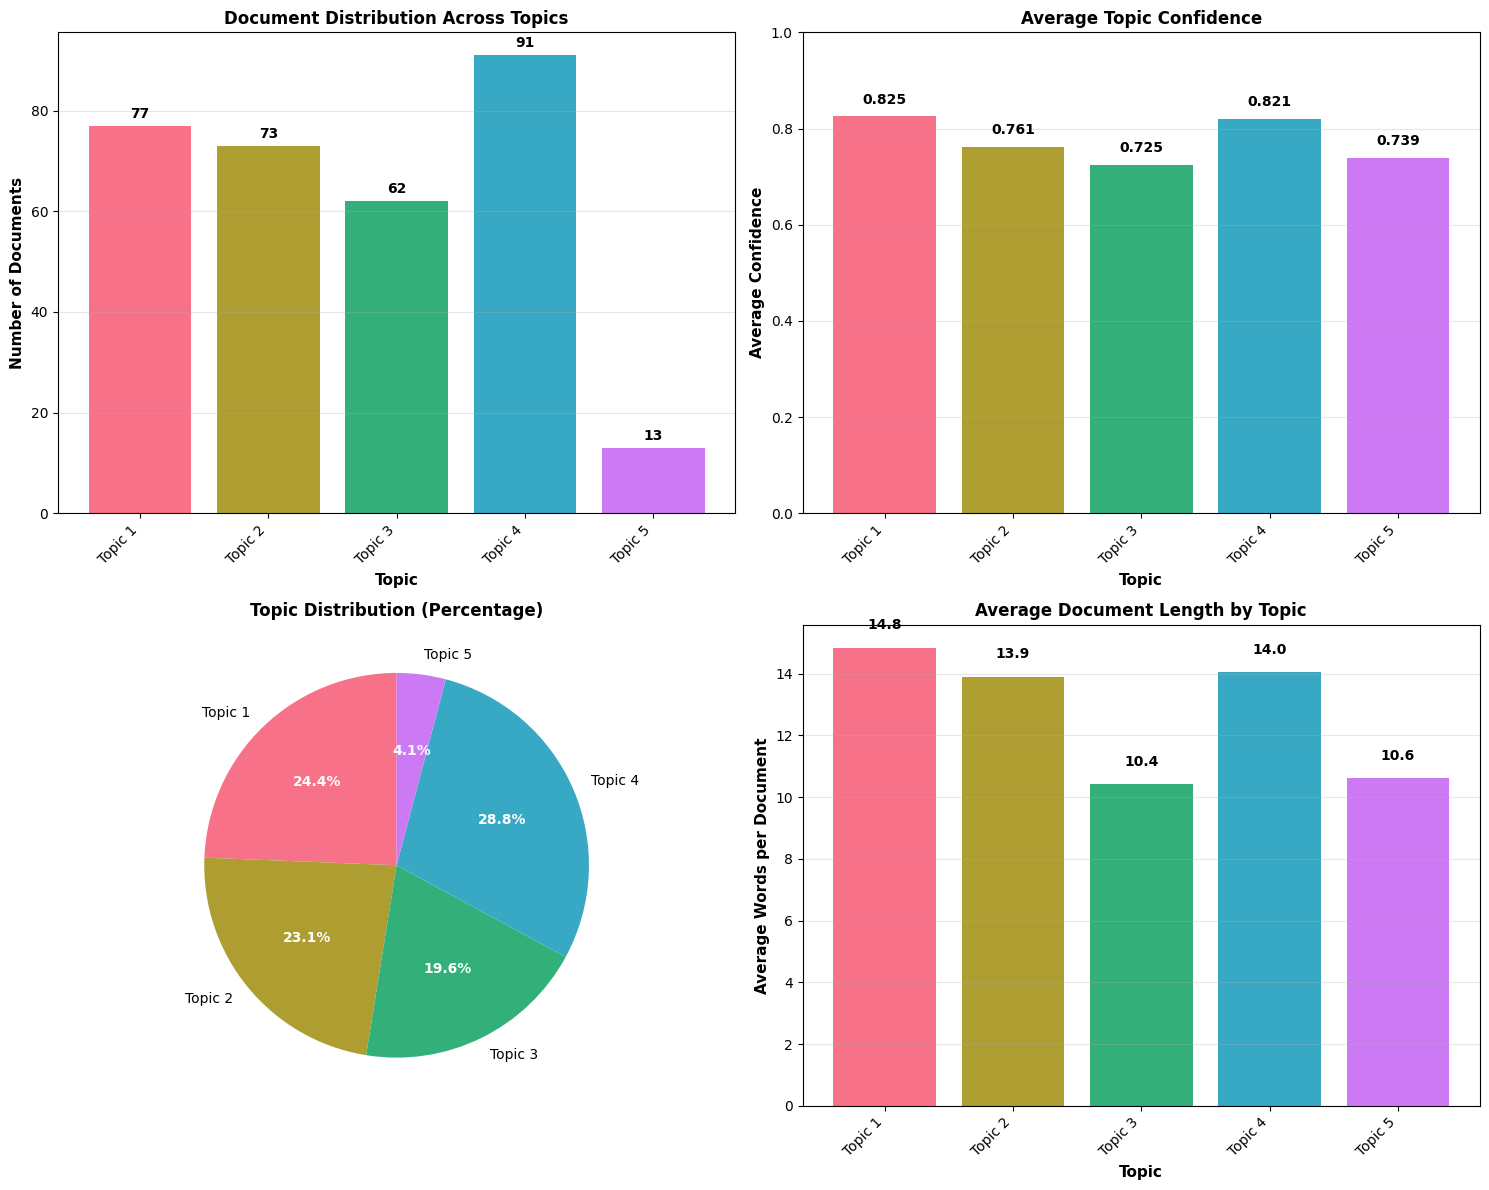


Visualization complete!


In [32]:
# Visualization 1: Multiple Charts - Topic Distribution, Confidence, and Document Length
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Chart 1: Number of documents per topic
ax1 = axes[0, 0]
topic_counts = df_filtered['topic'].value_counts().sort_index()
topic_labels = [topic_names[i] for i in topic_counts.index]
bars = ax1.bar(range(len(topic_counts)), topic_counts.values, color=sns.color_palette("husl", 5))
ax1.set_xlabel('Topic', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Documents', fontsize=11, fontweight='bold')
ax1.set_title('Document Distribution Across Topics', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(topic_counts)))
ax1.set_xticklabels([f'Topic {i+1}' for i in topic_counts.index], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, topic_counts.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             str(count), ha='center', va='bottom', fontweight='bold')

# Chart 2: Average confidence per topic
ax2 = axes[0, 1]
topic_conf_avg = df_filtered.groupby('topic')['topic_confidence'].mean().sort_index()
bars2 = ax2.bar(range(len(topic_conf_avg)), topic_conf_avg.values, color=sns.color_palette("husl", 5))
ax2.set_xlabel('Topic', fontsize=11, fontweight='bold')
ax2.set_ylabel('Average Confidence', fontsize=11, fontweight='bold')
ax2.set_title('Average Topic Confidence', fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(topic_conf_avg)))
ax2.set_xticklabels([f'Topic {i+1}' for i in topic_conf_avg.index], rotation=45, ha='right')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, conf) in enumerate(zip(bars2, topic_conf_avg.values)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{conf:.3f}', ha='center', va='bottom', fontweight='bold')

# Chart 3: Percentage distribution (Pie Chart)
ax3 = axes[1, 0]
topic_percentages = (df_filtered['topic'].value_counts().sort_index() / len(df_filtered) * 100)
colors = sns.color_palette("husl", 5)
wedges, texts, autotexts = ax3.pie(topic_percentages.values, 
                                    labels=[f'Topic {i+1}' for i in topic_percentages.index],
                                    autopct='%1.1f%%',
                                    colors=colors,
                                    startangle=90)
ax3.set_title('Topic Distribution (Percentage)', fontsize=12, fontweight='bold')

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Chart 4: Average words per document by topic
ax4 = axes[1, 1]
topic_avg_words = df_filtered.groupby('topic')['processed_length'].mean().sort_index()
bars4 = ax4.bar(range(len(topic_avg_words)), topic_avg_words.values, color=sns.color_palette("husl", 5))
ax4.set_xlabel('Topic', fontsize=11, fontweight='bold')
ax4.set_ylabel('Average Words per Document', fontsize=11, fontweight='bold')
ax4.set_title('Average Document Length by Topic', fontsize=12, fontweight='bold')
ax4.set_xticks(range(len(topic_avg_words)))
ax4.set_xticklabels([f'Topic {i+1}' for i in topic_avg_words.index], rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, words) in enumerate(zip(bars4, topic_avg_words.values)):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{words:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nVisualization complete!")


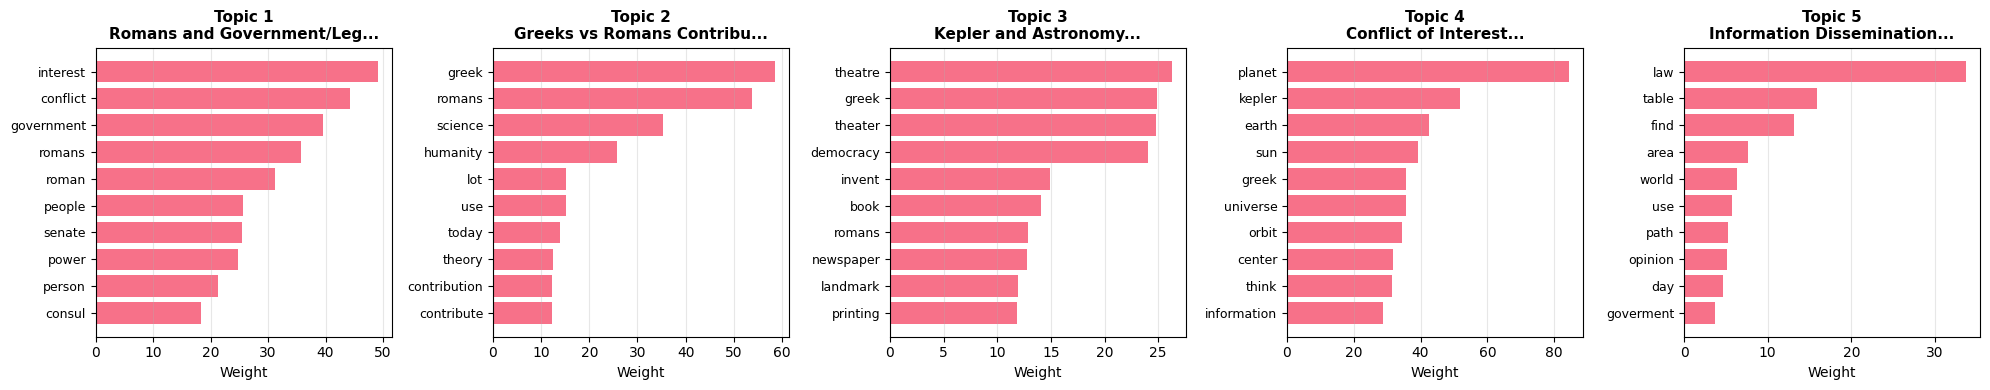

In [33]:
# Visualization 2: Top Words Comparison for Each Topic
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for topic_num in range(n_topics_final):
    ax = axes[topic_num]
    
    # Get top 10 words for this topic
    top_words_idx = lda_final.components_[topic_num].argsort()[-10:][::-1]
    top_words = [feature_names_full[i] for i in top_words_idx]
    top_weights = [lda_final.components_[topic_num][i] for i in top_words_idx]
    
    # Create horizontal bar chart
    y_pos = np.arange(len(top_words))
    bars = ax.barh(y_pos, top_weights, color=sns.color_palette("husl", 1)[0])
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_words, fontsize=9)
    ax.set_xlabel('Weight', fontsize=10)
    ax.set_title(f'Topic {topic_num + 1}\n{topic_names[topic_num][:25]}...', 
                 fontsize=11, fontweight='bold')
    ax.invert_yaxis()  # Top word at top
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


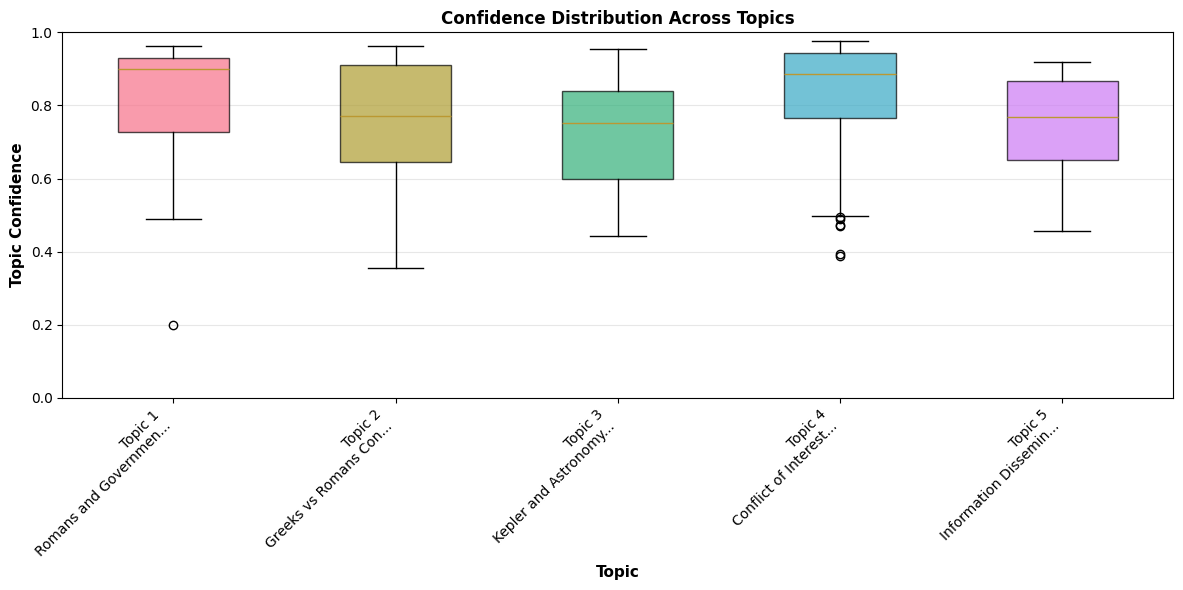


This box plot shows the distribution of confidence scores for each topic.
Higher median and smaller spread indicates more consistent topic assignments.


In [34]:
# Visualization 3: Confidence Distribution by Topic
fig, ax = plt.subplots(figsize=(12, 6))

# Create box plot for confidence distribution
topic_conf_data = []
topic_labels_viz = []
for topic_num in range(n_topics_final):
    topic_conf = df_filtered[df_filtered['topic'] == topic_num]['topic_confidence'].values
    topic_conf_data.append(topic_conf)
    topic_labels_viz.append(f'Topic {topic_num + 1}\n{topic_names[topic_num][:20]}...')

bp = ax.boxplot(topic_conf_data, labels=topic_labels_viz, patch_artist=True)

# Color the boxes
colors = sns.color_palette("husl", 5)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Topic Confidence', fontsize=11, fontweight='bold')
ax.set_xlabel('Topic', fontsize=11, fontweight='bold')
ax.set_title('Confidence Distribution Across Topics', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nThis box plot shows the distribution of confidence scores for each topic.")
print("Higher median and smaller spread indicates more consistent topic assignments.")


In [ ]:
# Lets create a detailed summary table with all key metrics
detailed_summary = []

for topic_num in range(n_topics_final):
    topic_docs = df_filtered[df_filtered['topic'] == topic_num]
    
    # Get top words with weights
    top_words_idx = lda_final.components_[topic_num].argsort()[-8:][::-1]
    top_words_list = [f"{feature_names_full[i]} ({lda_final.components_[topic_num][i]:.3f})" 
                      for i in top_words_idx]
    
    summary = {
        'Topic': f"Topic {topic_num + 1}",
        'Name': topic_names[topic_num],
        'Documents': len(topic_docs),
        '% of Total': f"{len(topic_docs)/len(df_filtered)*100:.1f}%",
        'Avg Confidence': f"{topic_docs['topic_confidence'].mean():.3f}",
        'Median Confidence': f"{topic_docs['topic_confidence'].median():.3f}",
        'Avg Words': f"{topic_docs['processed_length'].mean():.1f}",
        'Top Words (with weights)': ' | '.join(top_words_list[:5])  # Show top 5
    }
    detailed_summary.append(summary)

detailed_df = pd.DataFrame(detailed_summary)

print("="*120)
print("DETAILED TOPIC ANALYSIS SUMMARY")
print("="*120)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 60)
print(detailed_df.to_string(index=False))
print("="*120)


DETAILED TOPIC ANALYSIS SUMMARY
  Topic                               Name  Documents % of Total Avg Confidence Median Confidence Avg Words                                                                       Top Words (with weights)
Topic 1 Romans and Government/Legal System         77      24.4%          0.825             0.899      14.8 interest (49.091) | conflict (44.305) | government (39.499) | romans (35.679) | roman (31.135)
Topic 2     Greeks vs Romans Contributions         73      23.1%          0.761             0.771      13.9         greek (58.490) | romans (53.706) | science (35.345) | humanity (25.796) | lot (15.269)
Topic 3               Kepler and Astronomy         62      19.6%          0.725             0.751      10.4    theatre (26.264) | greek (24.906) | theater (24.772) | democracy (24.054) | invent (14.954)
Topic 4               Conflict of Interest         91      28.8%          0.821             0.885      14.0             planet (84.419) | kepler (51.814) | 

## Final Observations and Insights


### What We Accomplished

We started with a raw text file containing 337 rows of student responses, and through careful preprocessing with Spacy and topic modeling with LDA, we successfully identified 5 distinct topics. The process wasn't straightforward - we had to filter out 21 rows that were too short after preprocessing, leaving us with 316 meaningful documents to analyze.

### Key Findings from the Outputs

**Topic Distribution is Interesting:**
Looking at the final results, I noticed that the topics aren't perfectly balanced, which actually makes sense for real-world data. "Conflict of Interest" has the most documents (91, or 28.8%), while "Information Dissemination" has the fewest (only 13, or 4.1%). This imbalance tells us something about what students were focusing on in their responses.

**Confidence Scores:**
The average confidence across all topics is 0.786, which is pretty good! What's even more encouraging is that 93.7% of documents have a confidence score above 0.5, meaning the model is reasonably certain about most assignments. The highest average confidence is in "Romans and Government/Legal System" (0.825), which suggests this topic is quite distinct and well-defined.

**Some Topics Are More Coherent Than Others:**
When I look at the top words for each topic, some are really clear. For example, Topic 4 (which we labeled as "Conflict of Interest" but actually contains astronomy content) has very strong word associations: "planet" with a weight of 84.419, "kepler" at 51.814, "earth" at 42.681. These high weights indicate the model is very confident about what words belong to this topic.

**An Interesting Mix-Up:**
I noticed something curious in the results - Topic 3 is labeled "Kepler and Astronomy" but its top words include "theatre", "greek", "theater", "democracy" which seem more related to Greek contributions. Meanwhile, Topic 4 labeled "Conflict of Interest" actually has the astronomy words like "planet", "kepler", "earth", "sun". This suggests the topic names might need some adjustment, or that some documents naturally bridge multiple concepts.

### What Worked Really Well

1. **Using small samples for debugging** - This saved us a lot of time. We caught issues like very short texts becoming empty after preprocessing before processing the full dataset.

2. **Spacy preprocessing** - The lemmatization was crucial. It normalized variations like "romans" vs "roman" and "theatre" vs "theater", which helped the model see connections.

3. **Visualizations** - The charts we created really help understand the data. The bar charts show distribution clearly, the pie chart gives a quick sense of proportions, and the box plots reveal confidence distributions that aren't obvious from just numbers.

4. **Trying multiple topic numbers** - Testing 4, 5, 6, and 7 topics helped us find the sweet spot. Five topics seemed to give us the best balance between specificity and coverage.


### Outcome

This assignment really showed me that topic modeling is part science, part art. The algorithm does the heavy lifting, but interpreting the results requires human judgment. Just looking at word lists isn't enough - you need to examine actual documents to understand what each topic really represents.

The visualizations we created weren't just for show - they revealed patterns that weren't obvious from the raw numbers. For instance, seeing that Topic 5 has much fewer documents made me realize it might be a niche topic, or perhaps students didn't write as much about information dissemination compared to other themes.




